Cross-validation can be used for a variety of purposes in predictive modeling. These include:

Generating out-of-sample predictions from a neural network
Estimate a good number of epochs to train a neural network for (early stopping)
Evaluate the effectiveness of certain hyperparameters, such as activation functions, neuron counts, and layer counts
Cross-validation uses a number of folds, and multiple models, to provide each segment of data a chance to serve as both the validation and training set.

Regression: we use KFold cross validation.
Classification: we use stratifiedKFold cross validation as balance of classes is important.

# For Regression

In [8]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])
df

,id,job,area,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,product
0,1,vv,c,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,0.492126,0.071100,b
1,2,kd,c,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,0.342520,0.400809,c
2,3,pe,c,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,0.724409,0.207723,b
3,4,11,c,51690.0,15.808333,1,5.372942,16,4.333286,50,0.889764,0.444882,0.361216,b
4,5,kl,d,28347.0,40.941667,3,3.822477,20,5.967121,38,0.744094,0.661417,0.068033,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,vv,c,51017.0,38.233333,1,5.454545,34,14.013489,41,0.881890,0.744094,0.104838,b
1996,1997,kl,d,26576.0,33.358333,2,3.632069,20,8.380497,38,0.944882,0.877953,0.063851,a
1997,1998,kl,d,28595.0,39.425000,3,7.168218,99,4.626950,36,0.759843,0.744094,0.098703,f
1998,1999,qp,c,67949.0,5.733333,0,8.936292,26,3.281439,46,0.909449,0.598425,0.117803,c


In [9]:
df=pd.concat([df,pd.get_dummies(df['job'],prefix='job')],axis=1)
df=pd.concat([df,pd.get_dummies(df['area'],prefix='area')],axis=1)
df=pd.concat([df,pd.get_dummies(df['product'],prefix='prod')],axis=1)
df=df.drop(['job','area','product'],axis=1)

In [10]:
df.columns

Index(['id', 'income', 'aspect', 'subscriptions', 'dist_healthy', 'save_rate',
       'dist_unhealthy', 'age', 'pop_dense', 'retail_dense', 'crime', 'job_11',
       'job_al', 'job_am', 'job_ax', 'job_bf', 'job_by', 'job_cv', 'job_de',
       'job_dz', 'job_e2', 'job_f8', 'job_gj', 'job_gv', 'job_kd', 'job_ke',
       'job_kl', 'job_kp', 'job_ks', 'job_kw', 'job_mm', 'job_nb', 'job_nn',
       'job_ob', 'job_pe', 'job_po', 'job_pq', 'job_pz', 'job_qp', 'job_qw',
       'job_rn', 'job_sa', 'job_vv', 'job_zz', 'area_a', 'area_b', 'area_c',
       'area_d', 'prod_a', 'prod_b', 'prod_c', 'prod_d', 'prod_e', 'prod_f',
       'prod_g'],
      dtype='object')

In [11]:
df.isna().sum()

id                 0
income            59
aspect             0
subscriptions      0
dist_healthy       0
save_rate          0
dist_unhealthy     0
age                0
pop_dense          0
retail_dense       0
crime              0
job_11             0
job_al             0
job_am             0
job_ax             0
job_bf             0
job_by             0
job_cv             0
job_de             0
job_dz             0
job_e2             0
job_f8             0
job_gj             0
job_gv             0
job_kd             0
job_ke             0
job_kl             0
job_kp             0
job_ks             0
job_kw             0
job_mm             0
job_nb             0
job_nn             0
job_ob             0
job_pe             0
job_po             0
job_pq             0
job_pz             0
job_qp             0
job_qw             0
job_rn             0
job_sa             0
job_vv             0
job_zz             0
area_a             0
area_b             0
area_c             0
area_d       

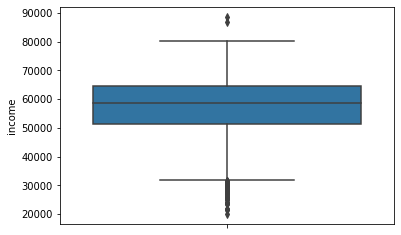

In [16]:
import seaborn as sns
sns.boxplot(y='income',data=df)

In [17]:
df['income'].describe()

count     1941.000000
mean     56924.861927
std      10188.938399
min      19846.000000
25%      51336.000000
50%      58633.000000
75%      64407.000000
max      88671.000000
Name: income, dtype: float64

In [18]:
df['income']=df['income'].fillna(df['income'].median())

In [20]:
df['income']=zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

In [23]:
x_columns=df.columns.drop(['age','id'])
x=df[x_columns].values
y=df['age'].values

In [34]:
import os
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
# Cross-Validate
kf = KFold(5, shuffle=True, random_state=42)
    
oos_y = []
oos_pred = []

fold = 0
for train, test in kf.split(x):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)    

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print(f"Fold score (RMSE): {score}")

Fold #1
Fold score (RMSE): 0.6285728658861756
Fold #2
Fold score (RMSE): 0.6135405020361389
Fold #3
Fold score (RMSE): 0.6752010060827243
Fold #4
Fold score (RMSE): 0.45641196683512303
Fold #5
Fold score (RMSE): 0.9625404239212146


In [35]:
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print(f"Final, out of sample score (RMSE): {score}")    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )

Final, out of sample score (RMSE): 0.6873468040421774


In [36]:
oosDF

,id,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,...,area_d,prod_a,prod_b,prod_c,prod_d,prod_e,prod_f,prod_g,0,0
0,1,-0.607550,-0.664918,-0.208449,9.017895,-0.215764,11.738935,49,0.885827,0.492126,...,0,0,1,0,0,0,0,0,47,47.911461
1,2,0.338053,-0.207748,0.839031,7.766643,0.196869,6.805396,51,0.874016,0.342520,...,0,0,0,1,0,0,0,0,49,49.504757
2,3,-0.184205,1.127906,-0.208449,3.632069,-0.714362,13.671772,44,0.944882,0.724409,...,0,0,1,0,0,0,0,0,46,45.086365
3,4,-0.526467,-0.440815,-0.208449,5.372942,-0.542432,4.333286,50,0.889764,0.444882,...,0,0,1,0,0,0,0,0,49,48.790100
4,5,-2.851675,1.638861,1.886511,3.822477,-0.473660,5.967121,38,0.744094,0.661417,...,1,1,0,0,0,0,0,0,37,36.685543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,-0.593504,1.414758,-0.208449,5.454545,-0.232957,14.013489,41,0.881890,0.744094,...,0,0,1,0,0,0,0,0,49,48.478546
1996,1997,-3.028085,1.011372,0.839031,3.632069,-0.473660,8.380497,38,0.944882,0.877953,...,1,1,0,0,0,0,0,0,47,46.323975
1997,1998,-2.826971,1.513363,1.886511,7.168218,0.884591,4.626950,36,0.759843,0.744094,...,1,0,0,0,0,0,1,0,49,49.099472
1998,1999,1.093101,-1.274478,-1.255928,8.936292,-0.370502,3.281439,46,0.909449,0.598425,...,0,0,0,1,0,0,0,0,44,43.544144


# Classification

In [37]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values


In [38]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# np.argmax(pred,axis=1)
# Cross-validate
kf = StratifiedKFold(5, shuffle=True, random_state=42) # Use for StratifiedKFold classification
    
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x,df['product']): # Must specify y for StratifiedKFold 
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)  

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print(f"Fold score (accuracy): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {score}")    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )

Fold #1
Fold score (accuracy): 0.6716417910447762
Fold #2
Fold score (accuracy): 0.6666666666666666
Fold #3
Fold score (accuracy): 0.7182044887780549
Fold #4
Fold score (accuracy): 0.6658291457286433
Fold #5
Fold score (accuracy): 0.6775818639798489
Final score (accuracy): 0.68


In [41]:
oosDF

,id,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,...,area_c,area_d,0,1,2,3,4,5,6,0
0,1,-0.607550,-0.664918,-0.208449,9.017895,-0.215764,11.738935,0.854321,0.885827,0.492126,...,1,0,0,1,0,0,0,0,0,1
1,2,0.338053,-0.207748,0.839031,7.766643,0.196869,6.805396,1.394432,0.874016,0.342520,...,1,0,0,1,0,0,0,0,0,1
2,3,-0.184205,1.127906,-0.208449,3.632069,-0.714362,13.671772,-0.495957,0.944882,0.724409,...,1,0,0,0,1,0,0,0,0,2
3,4,-0.526467,-0.440815,-0.208449,5.372942,-0.542432,4.333286,1.124377,0.889764,0.444882,...,1,0,0,1,0,0,0,0,0,1
4,5,-2.851675,1.638861,1.886511,3.822477,-0.473660,5.967121,-2.116291,0.744094,0.661417,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,-0.593504,1.414758,-0.208449,5.454545,-0.232957,14.013489,-1.306124,0.881890,0.744094,...,1,0,0,1,0,0,0,0,0,1
1996,1997,-3.028085,1.011372,0.839031,3.632069,-0.473660,8.380497,-2.116291,0.944882,0.877953,...,0,1,0,1,0,0,0,0,0,2
1997,1998,-2.826971,1.513363,1.886511,7.168218,0.884591,4.626950,-2.656402,0.759843,0.744094,...,0,1,0,0,0,0,0,1,0,5
1998,1999,1.093101,-1.274478,-1.255928,8.936292,-0.370502,3.281439,0.044154,0.909449,0.598425,...,1,0,0,1,0,0,0,0,0,1


# Cross validation and hold out for regression

In [42]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

In [43]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold

# Keep a 10% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.10) 


# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
for train, test in kf.split(x_main):        
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred) 

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print(f"Fold score (RMSE): {score}")


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print()
print(f"Cross-validated score (RMSE): {score}")    
    
# Write the cross-validated prediction (from the last neural network)
holdout_pred = model.predict(x_holdout)

score = np.sqrt(metrics.mean_squared_error(holdout_pred,y_holdout))
print(f"Holdout score (RMSE): {score}")


Fold #1
Fold score (RMSE): 0.7274323394809464
Fold #2
Fold score (RMSE): 0.5613542921884157
Fold #3
Fold score (RMSE): 0.6373533418422356
Fold #4
Fold score (RMSE): 0.6277793165849047
Fold #5
Fold score (RMSE): 24.180366071273887

Cross-validated score (RMSE): 10.828986157008272
Holdout score (RMSE): 24.366053464300524


# Cross validation and hold out for classification (Issue)

In [44]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split


# Keep a 10% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.10) 

# Cross-validate
kf = StratifiedKFold(5, shuffle=True, random_state=42) # Use for StratifiedKFold classification
    
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x_main,df['product'].loc[0:1799]): # Must specify y for StratifiedKFold 
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)  

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print(f"Fold score (accuracy): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {score}")    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )

In [54]:
oosDF

,id,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,...,area_c,area_d,0,1,2,3,4,5,6,0
0,1,-0.607550,-0.664918,-0.208449,9.017895,-0.215764,11.738935,0.854321,0.885827,0.492126,...,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1,2,0.338053,-0.207748,0.839031,7.766643,0.196869,6.805396,1.394432,0.874016,0.342520,...,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
2,3,-0.184205,1.127906,-0.208449,3.632069,-0.714362,13.671772,-0.495957,0.944882,0.724409,...,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,-0.526467,-0.440815,-0.208449,5.372942,-0.542432,4.333286,1.124377,0.889764,0.444882,...,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,-2.851675,1.638861,1.886511,3.822477,-0.473660,5.967121,-2.116291,0.744094,0.661417,...,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,-0.593504,1.414758,-0.208449,5.454545,-0.232957,14.013489,-1.306124,0.881890,0.744094,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,1997,-3.028085,1.011372,0.839031,3.632069,-0.473660,8.380497,-2.116291,0.944882,0.877953,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,1998,-2.826971,1.513363,1.886511,7.168218,0.884591,4.626950,-2.656402,0.759843,0.744094,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,1999,1.093101,-1.274478,-1.255928,8.936292,-0.370502,3.281439,0.044154,0.909449,0.598425,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# We can clearly see that this is overfit

# Solution to overfit is using L1/L2 Regularization

In [57]:
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values

In [58]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers

# Cross-validate
kf = KFold(5, shuffle=True, random_state=42)
    
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    #kernel_regularizer=regularizers.l2(0.01),
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], 
            activation='relu',
             activity_regularizer=regularizers.l1(1e-4))) # Hidden 1
    model.add(Dense(25, activation='relu', 
                    activity_regularizer=regularizers.l1(1e-4))) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)        

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print(f"Fold score (accuracy): {score}")


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {score}")    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )

Fold #1
Fold score (accuracy): 0.62
Fold #2
Fold score (accuracy): 0.695
Fold #3
Fold score (accuracy): 0.68
Fold #4
Fold score (accuracy): 0.6375
Fold #5
Fold score (accuracy): 0.625
Final score (accuracy): 0.6515


# Dropout to overcome the problem of overfitting

# Classification

In [59]:
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values

In [60]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers

# Cross-validate
kf = StratifiedKFold(5, shuffle=True, random_state=42)
    
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x,df['product']):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    #kernel_regularizer=regularizers.l2(0.01),
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='relu', activity_regularizer=regularizers.l1(1e-4))) # Hidden 2
    #model.add(Dropout(0.5)) # Usually do not add a dropout after final hidden layer
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=500)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)        

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print(f"Fold score (accuracy): {score}")


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {score}")    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )

Fold #1
Fold score (accuracy): 0.7039800995024875
Fold #2
Fold score (accuracy): 0.6666666666666666
Fold #3
Fold score (accuracy): 0.7256857855361596
Fold #4
Fold score (accuracy): 0.6959798994974874
Fold #5
Fold score (accuracy): 0.7002518891687658
Final score (accuracy): 0.6985


# Bootstrap: shuffle split for Regression

In [61]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values


In [65]:
import pandas as pd
import os
import numpy as np
import time
import statistics
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit

SPLITS = 50

# Bootstrap
boot = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=42)

# Track progress
mean_benchmark = []
epochs_needed = []
num = 0

# Loop through samples
for train, test in boot.split(x):
    start_time = time.time()
    num+=1

    # Split train and test
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]

    # Construct neural network
    model = Sequential()
    model.add(Dense(20, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=0, mode='auto', restore_best_weights=True)

    # Train on the bootstrap sample
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
    epochs = monitor.stopped_epoch
    epochs_needed.append(epochs)
    
    # Predict on the out of boot (validation)
    pred = model.predict(x_test)
  
    # Measure this bootstrap's log loss
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    mean_benchmark.append(score)
    m1 = statistics.mean(mean_benchmark)
    m2 = statistics.mean(epochs_needed)
    mdev = statistics.pstdev(mean_benchmark)
    
    # Record this iteration
    time_took = time.time() - start_time
    print(f"#{num}: score={score:.6f}, mean score={m1:.6f}, stdev={mdev:.6f}, epochs={epochs}, mean epochs={int(m2)}, time={time_took}")

#1: score=0.542110, mean score=0.542110, stdev=0.000000, epochs=126, mean epochs=126, time=19.135448455810547
#2: score=0.829474, mean score=0.685792, stdev=0.143682, epochs=114, mean epochs=120, time=16.69512152671814
#3: score=0.659827, mean score=0.677137, stdev=0.117953, epochs=150, mean epochs=130, time=22.770578622817993
#4: score=0.634677, mean score=0.666522, stdev=0.103792, epochs=109, mean epochs=124, time=16.331239223480225
#5: score=0.710136, mean score=0.675245, stdev=0.094459, epochs=81, mean epochs=116, time=12.585955142974854
#6: score=0.867405, mean score=0.707272, stdev=0.112089, epochs=127, mean epochs=117, time=20.845578908920288
#7: score=0.548239, mean score=0.684553, stdev=0.117754, epochs=121, mean epochs=118, time=21.773662090301514
#8: score=0.473699, mean score=0.658196, stdev=0.130367, epochs=122, mean epochs=118, time=17.98751473426819
#9: score=0.724164, mean score=0.665526, stdev=0.124647, epochs=101, mean epochs=116, time=15.780070543289185
#10: score=0.

# Bootstrap for classification

In [66]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values

In [67]:
import os
import numpy as np
import time
import statistics
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit

SPLITS = 50

# Bootstrap
boot = StratifiedShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=42)

# Track progress
mean_benchmark = []
epochs_needed = []
num = 0

# Loop through samples
for train, test in boot.split(x,df['product']):
    start_time = time.time()
    num+=1

    # Split train and test
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]

    # Construct neural network
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=25, verbose=0, mode='auto', restore_best_weights=True)

    # Train on the bootstrap sample
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
    epochs = monitor.stopped_epoch
    epochs_needed.append(epochs)
    
    # Predict on the out of boot (validation)
    pred = model.predict(x_test)
  
    # Measure this bootstrap's log loss
    y_compare = np.argmax(y_test,axis=1) # For log loss calculation
    score = metrics.log_loss(y_compare, pred)
    mean_benchmark.append(score)
    m1 = statistics.mean(mean_benchmark)
    m2 = statistics.mean(epochs_needed)
    mdev = statistics.pstdev(mean_benchmark)
    
    # Record this iteration
    time_took = time.time() - start_time
    print(f"#{num}: score={score:.6f}, mean score={m1:.6f}, stdev={mdev:.6f}, epochs={epochs}, mean epochs={int(m2)}, time={time_took}")


#1: score=0.657763, mean score=0.657763, stdev=0.000000, epochs=86, mean epochs=86, time=21.059149980545044
#2: score=0.648823, mean score=0.653293, stdev=0.004470, epochs=61, mean epochs=73, time=14.356209516525269
#3: score=0.678740, mean score=0.661775, stdev=0.012539, epochs=45, mean epochs=64, time=11.071472644805908
#4: score=0.650256, mean score=0.658896, stdev=0.011950, epochs=117, mean epochs=77, time=26.706393241882324
#5: score=0.683478, mean score=0.663812, stdev=0.014523, epochs=50, mean epochs=71, time=12.252638101577759
#6: score=0.684810, mean score=0.667312, stdev=0.015395, epochs=69, mean epochs=71, time=17.39631748199463
#7: score=0.699848, mean score=0.671960, stdev=0.018242, epochs=72, mean epochs=71, time=17.19881844520569
#8: score=0.747779, mean score=0.681437, stdev=0.030330, epochs=60, mean epochs=70, time=14.707688093185425
#9: score=0.601582, mean score=0.672564, stdev=0.038046, epochs=89, mean epochs=72, time=19.43750500679016
#10: score=0.661952, mean scor